## Data analysis

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data_default.csv', header=0)

In [19]:
df.head()

gpu          gemm input mode     m     n     k  \
NVIDIA_GH200_120GB D  normal01   fp64_int8_3     N    N  1024  1024  1024   
                   D  normal01   fp64_int8_9     N    N  1024  1024  1024   
                   D  normal01  fp64_int8_18     N    N  1024  1024  1024   
                   D  normal01         dgemm     N    N  1024  1024  1024   
                   D  normal01   fp64_int8_3     N    N  2048  2048  2048   

                          residual  max_relative  throughput_in_tflops  
NVIDIA_GH200_120GB D  2.401237e-05  2.757648e+01             15.468640  
                   D  2.275485e-16  5.395420e-12              3.109284  
                   D  2.275303e-16  1.286471e-15              0.876498  
                   D  1.066552e-15  9.625805e-10             52.867900  
                   D  2.717785e-05  3.946706e+01             37.601840

In [20]:
df['slices'] = df['gemm'].str.extract(r'fp64_int8_(\d+)').astype(float)
df.loc[df['gemm'] == 'dgemm', 'slices'] = 0

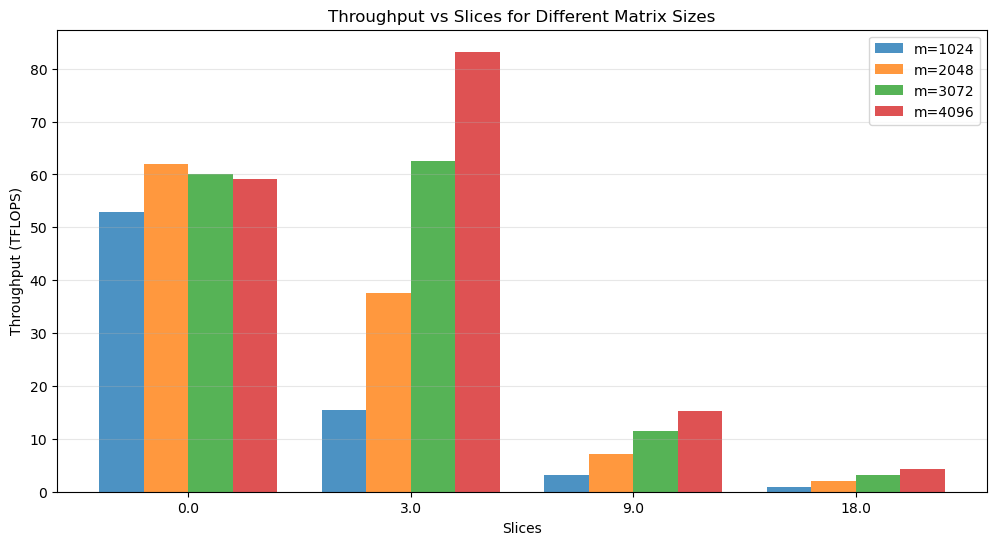

In [21]:
# Get unique matrix sizes (m values)
m_values = df['m'].unique()

# Get unique slice values (excluding NaN)
slice_values = df['slices'].dropna().unique()
slice_values = sorted(slice_values)

plt.figure(figsize=(12, 6))

width = 0.8 / len(m_values)  # Adjust width based on number of m values
x_pos = range(len(slice_values))

# Plot a bar for each m value
for i, m_val in enumerate(m_values):
    df_m = df[df['m'] == m_val].dropna(subset=['slices'])
    
    # Sort by slices to match x_pos
    df_m = df_m.sort_values('slices')
    
    offset = (i - len(m_values)/2 + 0.5) * width
    plt.bar([p + offset for p in x_pos], 
            df_m['throughput_in_tflops'], 
            width, 
            label=f'm={m_val}', 
            alpha=0.8)

plt.xlabel('Slices')
plt.ylabel('Throughput (TFLOPS)')
plt.title('Throughput vs Slices for Different Matrix Sizes')
plt.xticks(x_pos, slice_values)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## GB10 results

In [22]:
df_gb10 = pd.read_csv('data_gb10.csv', header=0)
df_gb10['slices'] = df_gb10['gemm'].str.extract(r'fp64_int8_(\d+)').astype(float)
df_gb10.loc[df_gb10['gemm'] == 'dgemm', 'slices'] = 0

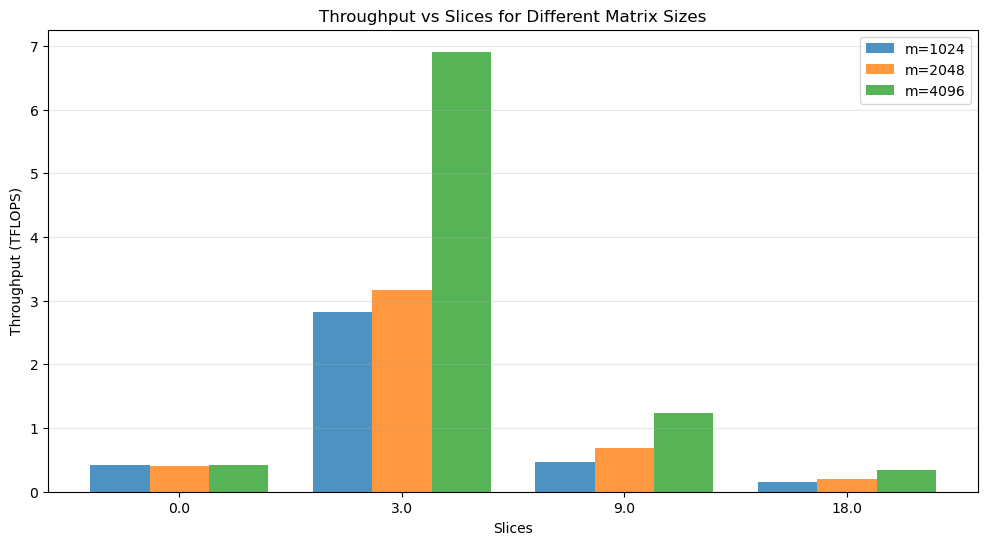

In [23]:
# Get unique matrix sizes (m values)
m_values = df_gb10['m'].unique()

# Get unique slice values (excluding NaN)
slice_values = df_gb10['slices'].dropna().unique()
slice_values = sorted(slice_values)

plt.figure(figsize=(12, 6))

width = 0.8 / len(m_values)  # Adjust width based on number of m values
x_pos = range(len(slice_values))

# Plot a bar for each m value
for i, m_val in enumerate(m_values):
    df_m = df_gb10[df_gb10['m'] == m_val].dropna(subset=['slices'])
    
    # Sort by slices to match x_pos
    df_m = df_m.sort_values('slices')
    
    offset = (i - len(m_values)/2 + 0.5) * width
    plt.bar([p + offset for p in x_pos], 
            df_m['throughput_in_tflops'], 
            width, 
            label=f'm={m_val}', 
            alpha=0.8)

plt.xlabel('Slices')
plt.ylabel('Throughput (TFLOPS)')
plt.title('Throughput vs Slices for Different Matrix Sizes')
plt.xticks(x_pos, slice_values)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [26]:
# Calculate and print performance increase for each m value when moving from 0 slices
print("Performance increase for GB10:")
print("=" * 80)

for m_val in sorted(df_gb10['m'].unique()):
    df_m_subset = df_gb10[df_gb10['m'] == m_val].sort_values('slices')
    baseline = df_m_subset[df_m_subset['slices'] == 0]['throughput_in_tflops'].values[0]
    
    print(f"\nMatrix size m={m_val}:")
    print(f"  Baseline (0 slices): {baseline:.2f} TFLOPS")
    
    for slices in [3.0, 9.0, 18.0]:
        if slices in df_m_subset['slices'].values:
            throughput = df_m_subset[df_m_subset['slices'] == slices]['throughput_in_tflops'].values[0]
            increase = ((throughput - baseline) / baseline) * 100
            speedup = throughput / baseline
            print(f"  {int(slices)} slices: {throughput:.2f} TFLOPS | {increase:+.2f}% | {speedup:.2f}x speedup")




Performance increase for GB10:

Matrix size m=1024:
  Baseline (0 slices): 0.41 TFLOPS
  3 slices: 2.83 TFLOPS | +584.51% | 6.85x speedup
  9 slices: 0.47 TFLOPS | +12.94% | 1.13x speedup
  18 slices: 0.15 TFLOPS | -62.72% | 0.37x speedup

Matrix size m=2048:
  Baseline (0 slices): 0.41 TFLOPS
  3 slices: 3.16 TFLOPS | +676.82% | 7.77x speedup
  9 slices: 0.69 TFLOPS | +68.62% | 1.69x speedup
  18 slices: 0.20 TFLOPS | -51.89% | 0.48x speedup

Matrix size m=4096:
  Baseline (0 slices): 0.42 TFLOPS
  3 slices: 6.91 TFLOPS | +1540.06% | 16.40x speedup
  9 slices: 1.24 TFLOPS | +193.14% | 2.93x speedup
  18 slices: 0.34 TFLOPS | -18.58% | 0.81x speedup
